In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score

import sys
path_name = r"C:\Users\User\Mon Drive\HEC\DSB\ML II\ML2_Forest"
sys.path.append(path_name)

from utils import clean_predictor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, HDBSCAN
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split


In [4]:
df_test = pd.read_csv(path_name + r"\test-full.csv")
df_train = pd.read_csv(path_name + r"\train.csv")
# pour avoir cover type au début
df_train = df_train[[df_train.columns[-1]] + list(df_train.columns[0:-1])]

In [90]:
# If we want to remove the soils

df_test_ns = df_test.loc[:, "Id": "Horizontal_Distance_To_Fire_Points"]
df_train_ns = df_train.loc[:, "Id": "Horizontal_Distance_To_Fire_Points"]

In [6]:
soil_types = [f"Soil_Type{i}" for i in range(1, 41)]
wilderness_areas = [f"Wilderness_Area{i}" for i in range(1,5)]
c = df_test[wilderness_areas] @ range(1,5)
df_train["Wilderness_Area_Synth"] = df_train[wilderness_areas] @ range(1,5)
df_test["Soil_Type_Synth"] = df_test[soil_types] @ range(1,41)
df_train["Soil_Type_Synth"] = df_train[soil_types] @ range(1,41)
df_train = df_train.drop(columns=wilderness_areas + soil_types)
df_test = df_test.drop(columns=wilderness_areas + soil_types)

((15120, 56), (581012, 55))

In [5]:
df_test.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type31  \
0            221             232            148  ...            0   
1            220             235            151  ...            0   
2            234             238            135  ...            0   
3            238             238            122  ...            0   
4            220             234            150  ...            0   

   Soil_Type32  Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type37  Soil_Type38  Soil_Type39  Soil_Type40  
0            0            0            0            0  
1            0            0            0            0  
2            0            0            0            0  
3            0            0            0            0  
4            0            0            0            0  

[5 rows x 55 columns]

In [62]:
df_train["Cover_Type"].value_counts()

1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
Name: Cover_Type, dtype: int64

### First train-test

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Si on met que la df en input
def RF_classif(df_train=df_train):
    
    if "Wilderness_Area_Synth" in df_train.columns:
        df_train = df_train.drop(columns="Wilderness_Area_Synth")

    
    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']

    data_train, data_test, target_train, target_test = train_test_split(
        X_train, y_train, test_size = 0.2
    )

    # Initialize and train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(data_train, target_train)

    # Make predictions on the test dataset
    y_pred = clf.predict(data_test)
    
    return target_test, y_pred

# Si test & train déjà définis
def RF_classif_train_test(data_train, target_train, data_test, target_test):

    # Initialize and train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(data_train, target_train)

    # Make predictions on the test dataset
    y_pred = clf.predict(data_test)
    
    return target_test, y_pred

In [36]:
y_true, y_pred = RF_classif()
accuracy_score(y_true, y_pred) # bien meilleur score que sur Kags

0.8839285714285714

In [37]:
print(classification_report(y_true, y_pred))

# On prédit moins bien 1 et 2, ce qui est un problème pcq représentent une immense majorité du dataset final

              precision    recall  f1-score   support

           1       0.80      0.81      0.80       431
           2       0.84      0.70      0.77       457
           3       0.88      0.87      0.88       449
           4       0.95      0.98      0.96       413
           5       0.91      0.96      0.93       419
           6       0.87      0.90      0.89       428
           7       0.94      0.98      0.96       427

    accuracy                           0.88      3024
   macro avg       0.88      0.89      0.88      3024
weighted avg       0.88      0.88      0.88      3024



In [54]:
from lightgbm import LGBMClassifier

# Separate features and target 
X_train = df_train.drop('Cover_Type', axis=1)
y_train = df_train['Cover_Type']

# Initialize and train a Random Forest classifier
clf = LGBMClassifier()
clf.fit(X_train, y_train)

# Make predictions on the test dataset
y_pred = clf.predict(df_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2421
[LightGBM] [Info] Number of data points in the train set: 15120, number of used features: 45
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


# Vizualisation

### Une TSNE

In [10]:
df_train_ns

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0      242642       2881     130     22                               210   
1      309891       3005     351     14                               242   
2      287847       3226      63     14                               618   
3      516307       3298     317      8                               661   
4      124860       3080      35      6                               175   
...       ...        ...     ...    ...                               ...   
15115  475155       3328     321     13                               323   
15116  514378       3455      37      5                               841   
15117  368425       3279      90     14                               404   
15118  537844       3589     357      9                               418   
15119  463634       3385     345     15                               350   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                  54                             1020   
1                                 -16                             1371   
2                                   2                             1092   
3                                  60                              752   
4                                  26                             3705   
...                               ...                              ...   
15115                              12                             5109   
15116                              92                              939   
15117                             113                             1513   
15118                              52                             1868   
15119                              76                             3625   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0                250             221             88   
1                194             215            159   
2                232             210            107   
3                198             233            174   
4                219             227            144   
...              ...             ...            ...   
15115            186             227            180   
15116            220             229            146   
15117            240             218            105   
15118            205             223            155   
15119            190             216            164   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                     342                 1                 0   
1                                     842                 0                 0   
2                                    2018                 1                 0   
3                                    1248                 0                 1   
4                                    2673                 1                 0   
...                                   ...               ...               ...   
15115                                3151                 0                 0   
15116                                 362                 0                 1   
15117                                1503                 1                 0   
15118                                1657                 0                 1   
15119                                3327                 0                 0   

       Wilderness_Area3  Wilderness_Area4  
0                     0                 0  
1                     1                 0  
2                     0                 0  
3                     0                 0  
4                     0                 0  
...                 ...               ...  
15115                 1                 0  
15116                 0                 0  
15117                 0                 0  
15118                 0                 0  
15119                 1                 0  

[15120 rows x 15 columns]

In [11]:
from sklearn.manifold import TSNE

X_train_ns = df_train_ns
y_train_ns = df_train['Cover_Type']

In [12]:
tsne = TSNE(verbose=True, n_components=2)
tsne_repr = tsne.fit_transform(X_train_ns)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 15120 samples in 0.036s...


[t-SNE] Computed neighbors for 15120 samples in 0.307s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15120
[t-SNE] Computed conditional probabilities for sample 2000 / 15120
[t-SNE] Computed conditional probabilities for sample 3000 / 15120
[t-SNE] Computed conditional probabilities for sample 4000 / 15120
[t-SNE] Computed conditional probabilities for sample 5000 / 15120
[t-SNE] Computed conditional probabilities for sample 6000 / 15120
[t-SNE] Computed conditional probabilities for sample 7000 / 15120
[t-SNE] Computed conditional probabilities for sample 8000 / 15120
[t-SNE] Computed conditional probabilities for sample 9000 / 15120
[t-SNE] Computed conditional probabilities for sample 10000 / 15120
[t-SNE] Computed conditional probabilities for sample 11000 / 15120
[t-SNE] Computed conditional probabilities for sample 12000 / 15120
[t-SNE] Computed conditional probabilities for sample 13000 / 15120
[t-SNE] Computed conditional probabilities for sample 14000 / 15120

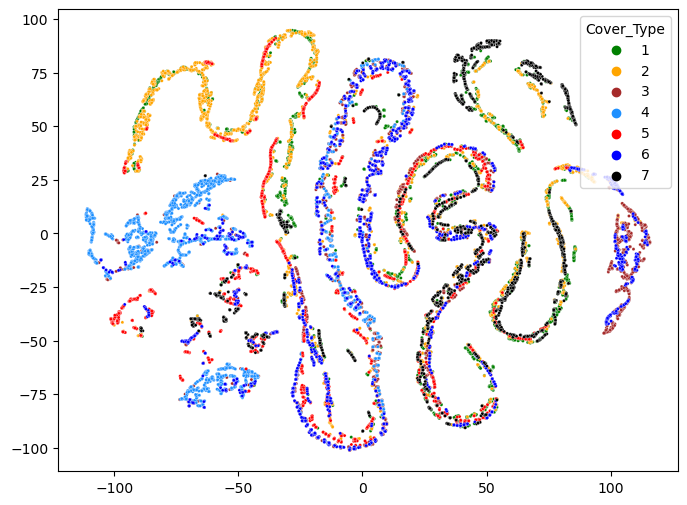

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_repr[:, 0], y=tsne_repr[:, 1], hue=y_train_ns,
                palette=['green','orange','brown','dodgerblue','red', 'blue', 'black'],
                s=5)
plt.show()

# PCA

### On df_train

In [91]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)
X_2D = pca.fit_transform(df_train_ns)

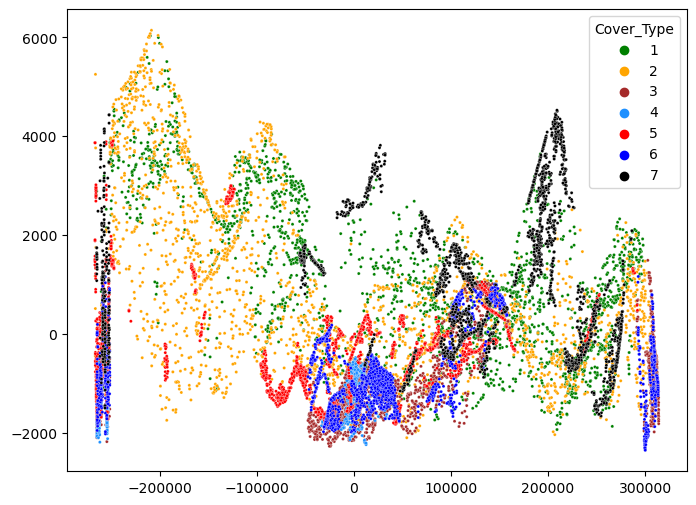

In [92]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2D[:, 0], y=X_2D[:, 1], hue=df_train["Cover_Type"],
                palette=['green','orange','brown','dodgerblue','red', 'blue', 'black'],
                s=5)
plt.show()
# On voit que les 1 et 2 sont beaucoup plus dispersés que les autres ici, ce qui peut expliquer la difficulté à les prédire

In [41]:
pca.explained_variance_ratio_

array([9.99899594e-01, 7.27579503e-05])

In [42]:
# On voit que la projection sur une dimension explique 99.99% de la variance (??) ==> A ELUCIDER 

In [43]:
pca2 = PCA(n_components=1)
X_test_10D = pca.fit_transform(df_test)
pca.explained_variance_ratio_
# Pareil pour df_test !

array([9.99867467e-01, 8.17774791e-05])

In [44]:
pca = PCA(n_components=1)
X_1D = pca.fit_transform(df_train_ns)
df_reduced = pd.DataFrame(np.stack([df_train["Cover_Type"], X_1D.ravel()]).T, columns=["Cover_Type", "1D"])

In [45]:
from utils import classif

y_true, y_pred = classif(df_reduced)
accuracy_score(y_true, y_pred) # on arrive à 67% d'accuracy avec une seule dimension !!!!!!

0.669973544973545

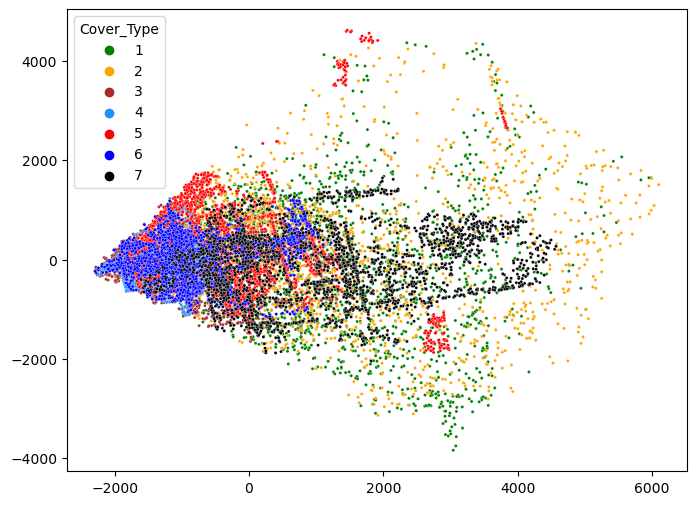

In [46]:
### Si on essaie les ID

from sklearn.decomposition import PCA 

pca = PCA(n_components=2)
X_2D = pca.fit_transform(df_train_ns.drop(columns='Id'))
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_2D[:, 0], y=X_2D[:, 1], hue=df_train["Cover_Type"],
                palette=['green','orange','brown','dodgerblue','red', 'blue', 'black'],
                s=5)
plt.show()
# On voit que les 1 et 2 sont beaucoup plus dispersés que les autres ici, ce qui peut expliquer la difficulté à les prédire

In [47]:
pca.explained_variance_ratio_.sum() # Plus réaliste et déjà pas mal

0.9484606688511418

In [48]:
df_reduced = pd.DataFrame(np.c_[df_train["Cover_Type"], X_2D], columns=["Cover_Type", "1D", "2D"])
y_true, y_pred = classif(df_reduced)
accuracy_score(y_true, y_pred)

0.44246031746031744

In [49]:
# bizarre parce que semble largement déterminé par la scale des features
# (expliqué à 99% pcq échelle des indices de loin supérieure mais ne change rien quand on scale - heureusement pcq pca censée déjà scaler)

### Plotting df_test

<Axes: >

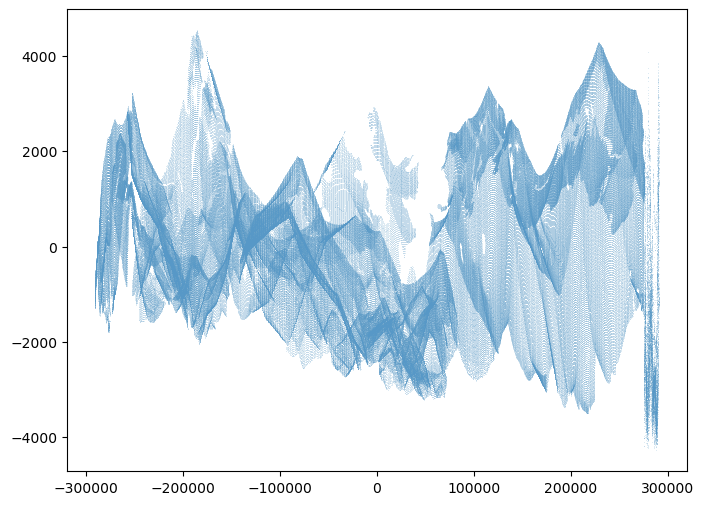

In [50]:
pca = PCA(n_components=2)
Xtest_2D = pca.fit_transform(df_test_ns)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Xtest_2D[:, 0], y=Xtest_2D[:, 1], s=0.1)

<Axes: >

c:\Users\User\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


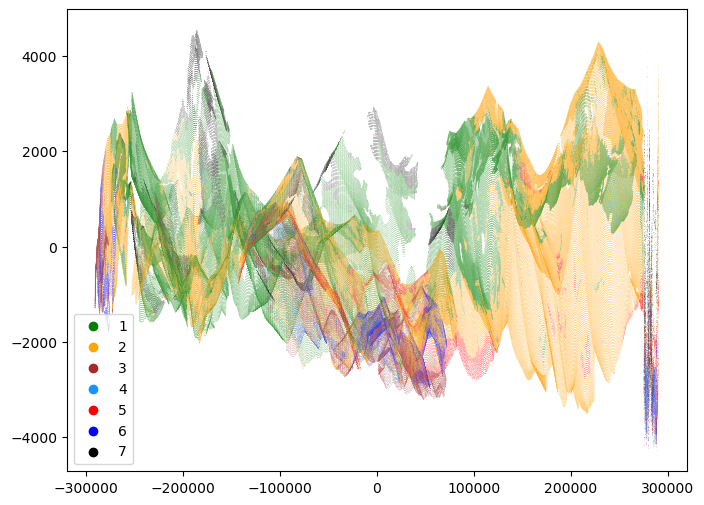

In [56]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Xtest_2D[:, 0], y=Xtest_2D[:, 1], s=0.1, hue=y_pred,
                palette=['green','orange','brown','dodgerblue','red', 'blue', 'black'])

<Axes: >

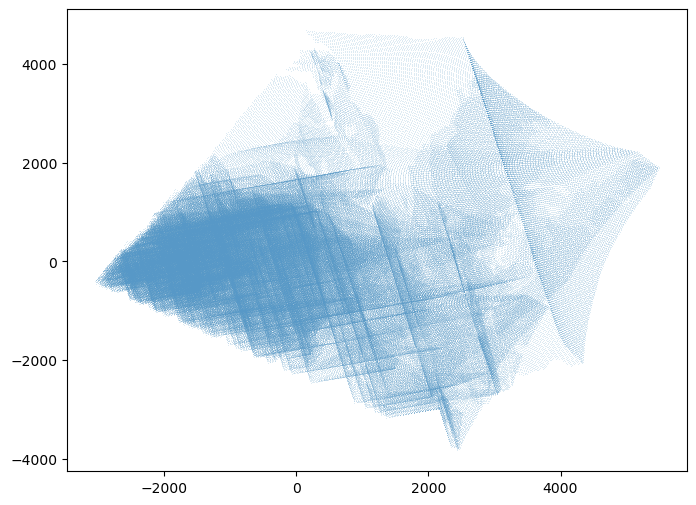

In [57]:
# Et sans les IDs

df_test_nsid = df_test_ns.drop(columns="Id")

pca = PCA(n_components=2)
Xtest_2D = pca.fit_transform(df_test_nsid)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Xtest_2D[:, 0], y=Xtest_2D[:, 1], s=0.1)

### Scaling

<Axes: >

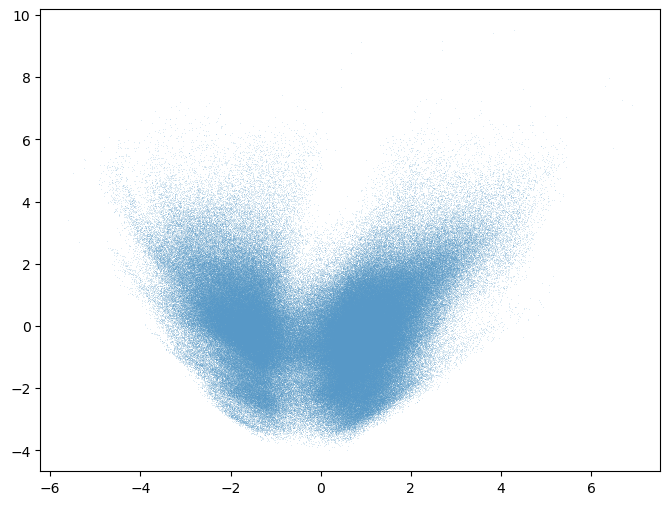

In [93]:
scaler = StandardScaler()
df_test_ns_scaled = pd.DataFrame(scaler.fit_transform(df_test_ns), columns=df_test_ns.columns)
df_train_ns_scaled = pd.DataFrame(scaler.transform(df_train_ns), columns=df_train_ns.columns)

pca = PCA(n_components=2)
Xtest_2D = pca.fit_transform(df_test_ns_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Xtest_2D[:, 0], y=Xtest_2D[:, 1], s=0.1)

<Axes: >

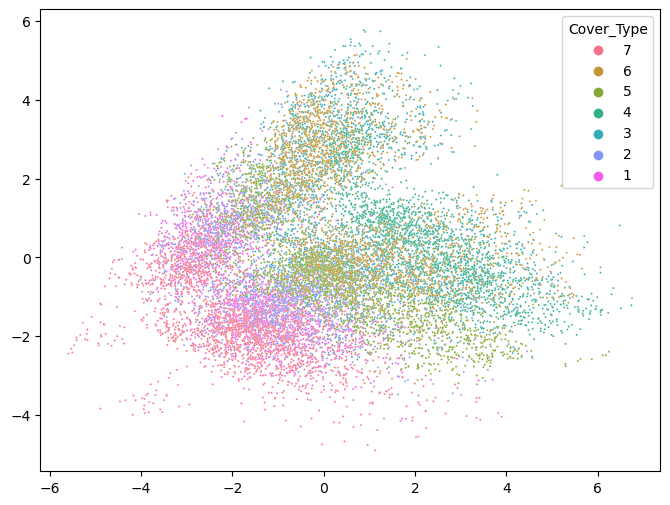

In [94]:
pca = PCA(n_components=2)
Xtest_2D = pca.fit_transform(df_train_ns_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Xtest_2D[:, 0], y=Xtest_2D[:, 1], s=2, hue=df_train["Cover_Type"],
                palette=sns.color_palette("husl", 7), hue_order=range(7,0,-1))

### Trying to reduce the number of dimensions

In [99]:
pca = PCA(n_components=11)
XtestD = pca.fit_transform(df_test_ns_scaled)
pca.explained_variance_ratio_.cumsum()

array([0.23621337, 0.44154085, 0.60228677, 0.72774162, 0.80875843,
       0.86845047, 0.91068845, 0.94631477, 0.97489552, 0.99969085,
       1.        ])

In [116]:
# Setting class weights
coeffs = np.array([2.63, 3.06, 0.43, 0.05, 0.24, 0.27, 0.32])
sample_weight = pd.Series([coeffs[i - 1] for i in df_train["Cover_Type"]])
y_train = df_train['Cover_Type']
predict_true = pd.read_parquet(path_name + r"\ground_truth.parquet")["Cover_Type"]

for dims in range(1, 12):

    pca = PCA(n_components=dims)
    XtestD = pca.fit_transform(df_test_ns_scaled)
    XtestD = pd.DataFrame(XtestD, columns=range(dims))
    
    A = pca.transform(df_train_ns_scaled)
    A = pd.DataFrame(A, columns=range(dims))
    
    # Adding categ columns
    XtestD["Wilderness_Area_Synth"] = df_test["Wilderness_Area_Synth"]
    XtestD["Soil_Type_Synth"] = df_test["Soil_Type_Synth"]
    A["Wilderness_Area_Synth"] = df_train["Wilderness_Area_Synth"]
    A["Soil_Type_Synth"] = df_train["Soil_Type_Synth"]

    # Setting classifier
    clf = LGBMClassifier(
        objective='multiclass',
        num_class=7,
        verbose=0,
        n_jobs=-1
    )

    # Predicting
    clf.fit(A, y_train, categorical_feature=['Wilderness_Area_Synth', 'Soil_Type_Synth'],
        sample_weight=sample_weight)
    y_pred = clf.predict(XtestD)
    predictions_df = clean_predictor(y_pred)
    print(f"{dims} dimensions")
    print(f"Score: {accuracy_score(predictions_df['Cover_Type'], predict_true)}")


1 dimensions
Score: 0.6244965680571142
2 dimensions
Score: 0.6323483852312861
3 dimensions
Score: 0.6593013569427137
4 dimensions
Score: 0.6882955945832444
5 dimensions
Score: 0.7222914500905316
6 dimensions
Score: 0.7472083192773987
7 dimensions
Score: 0.7467659876215982
8 dimensions
Score: 0.7507400879844134
9 dimensions
Score: 0.7583543885496341
10 dimensions
Score: 0.7644386002354513
11 dimensions
Score: 0.7620582707413961


# Kmeans

In [25]:
# Si on part de df_train pour regarder les clusters sur df_test

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, n_init=5, init="k-means++")
y_pred = kmeans.fit_predict(df_train_ns)

In [27]:
pd.Series(y_pred).value_counts()

0    6791
1    4286
2    4043
dtype: int64

In [28]:
df_train_ns

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0      242642       2881     130     22                               210   
1      309891       3005     351     14                               242   
2      287847       3226      63     14                               618   
3      516307       3298     317      8                               661   
4      124860       3080      35      6                               175   
...       ...        ...     ...    ...                               ...   
15115  475155       3328     321     13                               323   
15116  514378       3455      37      5                               841   
15117  368425       3279      90     14                               404   
15118  537844       3589     357      9                               418   
15119  463634       3385     345     15                               350   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                                  54                             1020   
1                                 -16                             1371   
2                                   2                             1092   
3                                  60                              752   
4                                  26                             3705   
...                               ...                              ...   
15115                              12                             5109   
15116                              92                              939   
15117                             113                             1513   
15118                              52                             1868   
15119                              76                             3625   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0                250             221             88   
1                194             215            159   
2                232             210            107   
3                198             233            174   
4                219             227            144   
...              ...             ...            ...   
15115            186             227            180   
15116            220             229            146   
15117            240             218            105   
15118            205             223            155   
15119            190             216            164   

       Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  \
0                                     342                 1                 0   
1                                     842                 0                 0   
2                                    2018                 1                 0   
3                                    1248                 0                 1   
4                                    2673                 1                 0   
...                                   ...               ...               ...   
15115                                3151                 0                 0   
15116                                 362                 0                 1   
15117                                1503                 1                 0   
15118                                1657                 0                 1   
15119                                3327                 0                 0   

       Wilderness_Area3  Wilderness_Area4  
0                     0                 0  
1                     1                 0  
2                     0                 0  
3                     0                 0  
4                     0                 0  
...                 ...               ...  
15115                 1                 0  
15116                 0                 0  
15117                 0                 0  
15118                 0                 0  
15119                 1                 0  

[15120 rows x 15 columns]

In [29]:
pd.Series(kmeans.predict((df_test_ns))).value_counts()

0    229506
2    194419
1    157087
dtype: int64

In [30]:
kmeans.transform(df_test_ns.iloc[0:3])

array([[282008.23857878,  32544.46989751, 491246.89571431],
       [282006.70549159,  32541.34894524, 491245.78019775],
       [282007.28266546,  32516.15172914, 491242.57054947]])

### Best number of clusters

In [31]:
# En comparant si on part de df_train et df_test

In [32]:
inertias = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, n_init=5, init="k-means++")
    kmeans.fit(df_train_ns)
    inertias.append(kmeans.inertia_)

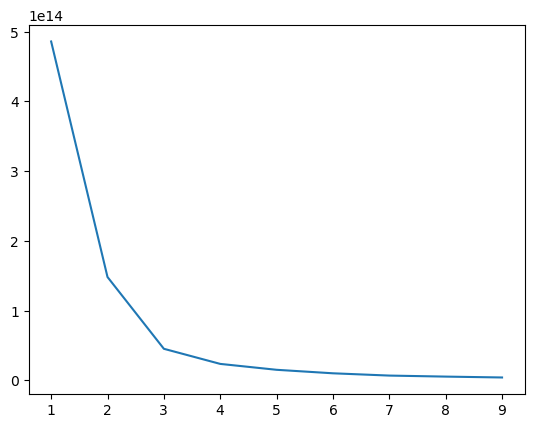

In [33]:
plt.plot(range(1, 10), inertias)

In [34]:
inertias = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, n_init=5, init="k-means++")
    kmeans.fit(df_test_ns)
    inertias.append(kmeans.inertia_)

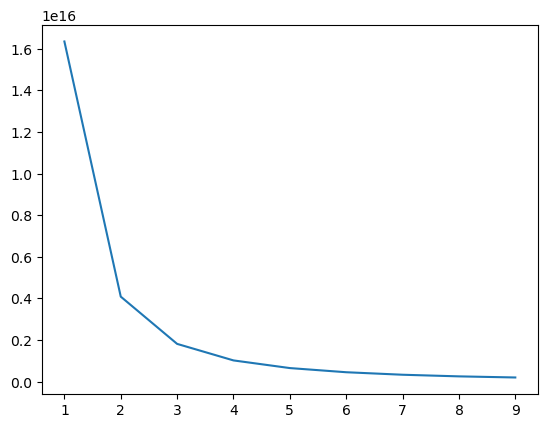

In [35]:
plt.plot(range(1,10), inertias)

In [36]:
from sklearn.metrics import silhouette_score

ss = []

for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, n_init=5, init="k-means++")
    kmeans.fit(df_train_ns)
    ss.append(silhouette_score(df_train_ns, kmeans.labels_))

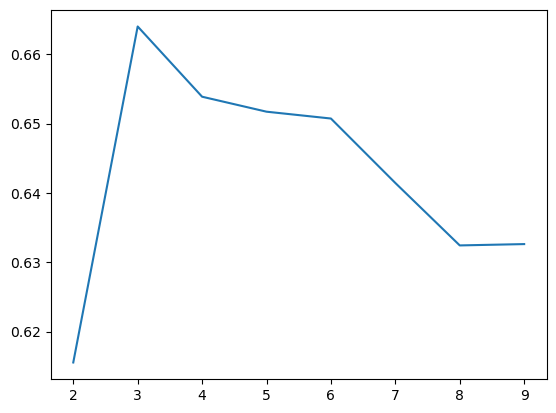

In [37]:
plt.plot(range(2, 10), ss)

2
3
4
5
6
7
8
9


C:\Users\User\AppData\Local\Temp\ipykernel_27176\3062962871.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color = plt.cm.get_cmap("Spectral")(float(j) / n_clusters)


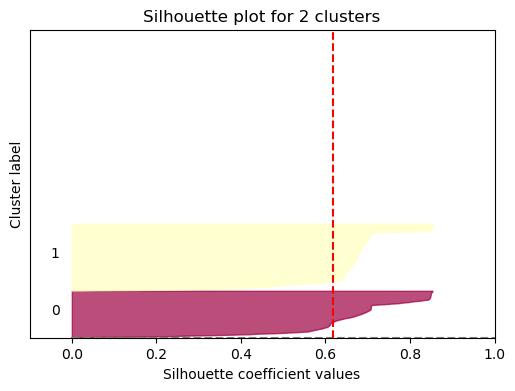

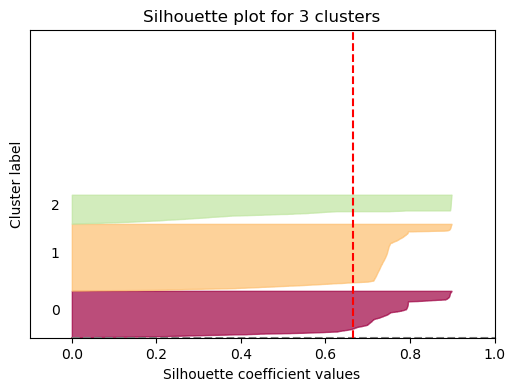

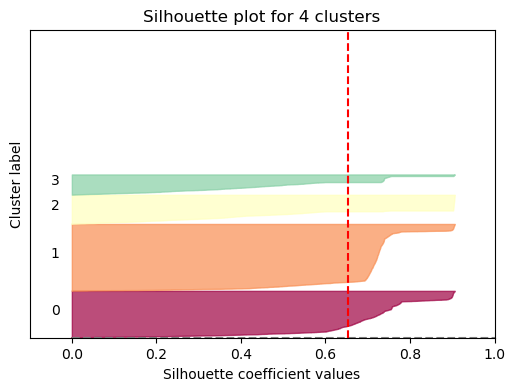

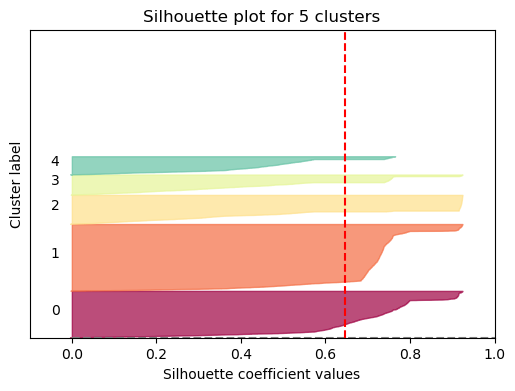

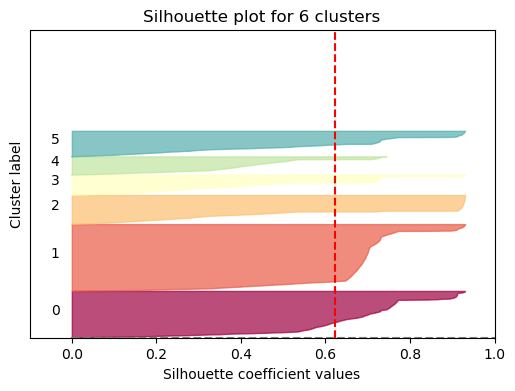

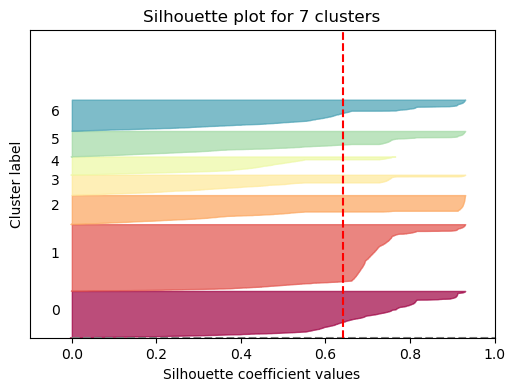

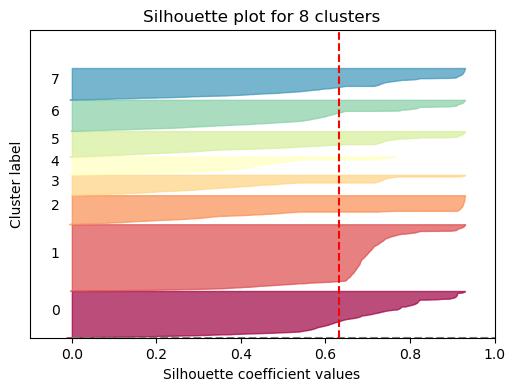

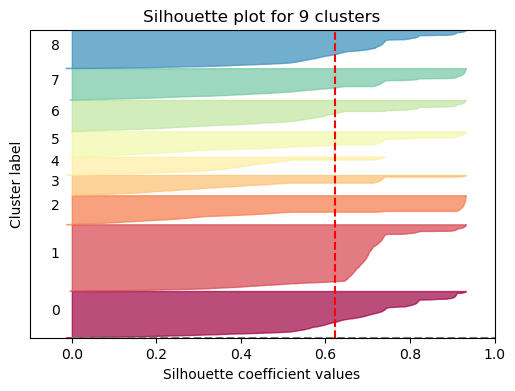

In [38]:
from sklearn.metrics import silhouette_samples

X = df_train_ns
range_n_clusters = range(2, 10)
silhouette_scores = []
sample_silhouette_values = []

for n_clusters in range_n_clusters:
    # Initialize and fit KMeans clustering algorithm
    print(n_clusters)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Compute the silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    
    # Compute the silhouette values for each sample
    sample_silhouette_values.append(silhouette_samples(X, cluster_labels))

for i, n_clusters in enumerate(range_n_clusters):
    plt.figure(figsize=(6, 4))
    plt.plot([0, 1], [i, i], '--', color='gray')  # Plot silhouette score reference line
    plt.yticks([])  # Clear the y-axis labels
    plt.xlim([-0.1, 1])  # Set the x-axis limits
    plt.ylim([0, len(X) + (n_clusters + 1) * 10])  # Set the y-axis limits
    
    silhouette_values = sample_silhouette_values[i]
    silhouette_values.sort()
    
    y_lower = 10
    for j in range(n_clusters):
        cluster_silhouette_values = silhouette_values[cluster_labels == j]
        cluster_silhouette_values.sort()
        size_cluster_j = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j
        color = plt.cm.get_cmap("Spectral")(float(j) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10
    
    plt.title("Silhouette plot for {} clusters".format(n_clusters))
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.axvline(x=silhouette_scores[i], color="red", linestyle="--")  # Plot average silhouette score
    plt.show()

### Same clusters if we do it on test or train?

In [39]:
km_train = KMeans(n_clusters=3, n_init=10, init="k-means++")
km_train.fit_predict(df_train_ns)
c1 = km_train.cluster_centers_

km_test = KMeans(n_clusters=3, n_init=10, init="k-means++")
km_test.fit_predict(df_test_ns)
c2 =km_test.cluster_centers_

In [40]:
norms = np.zeros((3, 3))

for i in range(3):
    for j in range(3):
        norms[i, j] = np.linalg.norm(c1[i] - c2[j])
        
norms / 1000

#### Seems to be giving relatively similar results

array([[199.57845043, 393.69217435,   6.35028169],
       [259.18729803,  65.10237096, 452.4161961 ],
       [  9.58892538, 184.54803382, 202.80881266]])

In [41]:
# If we do it on the full ds, what's the labels distribution on train
# On dirait que clusterise bien pareil même si on entraine 
pd.Series(km_test.predict(df_train_ns)).value_counts()

0    6375
1    4740
2    4005
dtype: int64

In [64]:
df_test["kmean_cluster"] = km_test.labels_
df_train["kmean_cluster"] = km_test.predict(df_train_ns)

In [65]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

X_train = df_train.drop('Cover_Type', axis=1)
y_train = df_train['Cover_Type']

data_train, data_test, target_train, target_test = train_test_split(
    X_train, y_train, test_size = 0.2)

cat_col = ["kmean_cluster"]
cols = df_train.drop(columns=["Cover_Type", 'kmean_cluster']).columns

preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_col),
        ("others", "passthrough", cols),
    ])

clf = RandomForestClassifier(n_estimators=150)
pipe = make_pipeline(preprocessor, clf)

pipe.fit(data_train, target_train)

y_pred = pipe.predict(data_test)

In [66]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           1       0.79      0.78      0.79       451
           2       0.80      0.69      0.74       420
           3       0.87      0.86      0.86       414
           4       0.94      0.98      0.96       491
           5       0.89      0.98      0.93       408
           6       0.87      0.86      0.86       417
           7       0.94      0.97      0.95       423

    accuracy                           0.87      3024
   macro avg       0.87      0.87      0.87      3024
weighted avg       0.87      0.87      0.87      3024



In [67]:
from utils import IWCV
IWCV(df_train=df_train, predictor=pipe, k_valid=20)

(0.806434968988599,
 array([0.81803431, 0.74840623, 0.8699146 , 0.9733959 , 0.96379196,
        0.87522431, 0.97855561]))

In [ ]:
### Testons différents clusters et l'impact: 
# amélioration globale légère mais à part ça dur de dire lequel est censé être mieux
# normal puisque nos cibles ont ici des tailles incroyablement différentes

# 6 semble ici être le meilleur mais bon

In [ ]:
# 3 (0.7964317147617246, array([0.80137661, 0.74018367, 0.86667338, 0.97626767, 0.95692951,
#        0.88469327, 0.97633215]))
# 4 (0.8063791783292583, array([0.81147599, 0.7509015 , 0.87668574, 0.97692516, 0.9623179 ,
#        0.89499291, 0.98215092]))
# 5 (0.7973268895390577, array([0.80508998, 0.73625063, 0.87534417, 0.97047013, 0.97040958,
#        0.88565691, 0.98133588]))
# 6 (0.8138732156589155, array([0.82406566, 0.7590603 , 0.87264768, 0.97611052, 0.96225996,
#        0.88922548, 0.9750562 ]))
# 7 (0.8025745240127359, array([0.81797665, 0.73892822, 0.87166264, 0.97420566, 0.95712525,
#        0.88150201, 0.98244342]))
# 8 (0.8059379238503376, array([0.81540698, 0.74684563, 0.87582675, 0.96810505, 0.97035152,
#        0.88794631, 0.98142766]))
# 9 (0.8138747765220707, array([0.80690948, 0.77089976, 0.88889744, 0.97303765, 0.9627102 ,
#        0.89193328, 0.97890003]))
# 10 (0.8046872549494163, array([0.81832363, 0.74217926, 0.87083945, 0.97714715, 0.96876801,
#        0.89176928, 0.97797113]))
# 11 (0.8101769386975759, array([0.82034927, 0.75321916, 0.87373846, 0.9793508 , 0.96630527,
#        0.87908902, 0.98414675]))

# 3 (0.8091096600808318, array([0.81079015, 0.75869236, 0.88729933, 0.97445768, 0.95445724,
#        0.87974177, 0.97790399]))
# 4 (0.8043271518888415, array([0.80477863, 0.75080844, 0.88753435, 0.97432924, 0.96106419,
#        0.88896709, 0.98504902]))
# 5 (0.8085925468936838, array([0.8117079 , 0.75697941, 0.87493372, 0.97626658, 0.96696487,
#        0.88544683, 0.97756879]))
# 6 (0.8133828296403914, array([0.82732881, 0.75311597, 0.88433786, 0.97279678, 0.9596562 ,
#        0.89336551, 0.97762147]))
# 7 (0.8091068135960581, array([0.8014788 , 0.76791348, 0.86982589, 0.97626454, 0.9569986 ,
#        0.88568719, 0.98246762]))
# 8 (0.8041301715932397, array([0.81805564, 0.73995522, 0.88289342, 0.97306012, 0.96713386,
#        0.88568317, 0.98005667]))
# 9 (0.8066946762534507, array([0.80211876, 0.76039546, 0.86924134, 0.96934032, 0.96188595,
#        0.8987365 , 0.98352502]))
# 10 (0.8143313394097335, array([0.82199016, 0.76137033, 0.87446658, 0.97673993, 0.95933104,
#        0.88960218, 0.97938239]))
# 11 (0.8045071041145079, array([0.81653566, 0.74225301, 0.87598252, 0.9680956 , 0.96338752,
#        0.89302712, 0.98549733]))

# 6 (0.8148632825506185, array([0.82059708, 0.76388664, 0.88091409, 0.97495579, 0.95835447,
#        0.88032613, 0.97857982]))



# DB Scan

### Avec ID

In [4]:
soil_types = [f"Soil_Type{i}" for i in range(1, 41)]
wilderness_areas = [f"Wilderness_Area{i}" for i in range(1,5)]
df_test["Wilderness_Area_Synth"] = df_test[wilderness_areas] @ range(1,5)
df_train["Wilderness_Area_Synth"] = df_train[wilderness_areas] @ range(1,5)
df_test["Soil_Type_Synth"] = df_test[soil_types] @ range(1,41)
df_train["Soil_Type_Synth"] = df_train[soil_types] @ range(1,41)
df_train = df_train.drop(columns=wilderness_areas + soil_types)
df_test = df_test.drop(columns=wilderness_areas + soil_types)

In [21]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=400, min_samples=15, n_jobs=-1)
dbscan.fit(df_test_ns)

DBSCAN(eps=400, min_samples=15, n_jobs=-1)

In [22]:
pd.Series(dbscan.labels_).value_counts()

58      176164
1237     44913
1408     33561
57       30765
1092     23247
         ...  
1246        10
835         10
832         10
615          6
618          5
Length: 1410, dtype: int64

<Axes: >

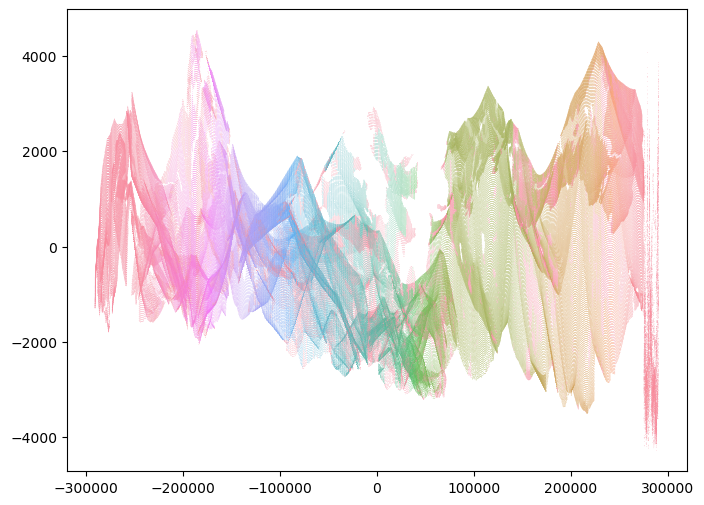

In [7]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
Xtest_2D = pca.fit_transform(df_test_ns)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Xtest_2D[:, 0], y=Xtest_2D[:, 1], s=0.1, hue=dbscan.labels_,
                palette=sns.color_palette("husl", len(pd.Series(dbscan.labels_).value_counts())),
                legend=False)

In [23]:
df_test["DBScan"] = dbscan.labels_ + 1
df_train["DBScan"] = list(df_test[df_test["Id"].isin(df_train["Id"])]["DBScan"])

In [24]:
df_train["DBScan"].value_counts()

59      2035
10      1628
1409    1036
1238     660
42       535
        ... 
509        1
516        1
520        1
523        1
434        1
Name: DBScan, Length: 1100, dtype: int64

In [25]:
vc = pd.DataFrame(df_train["DBScan"].value_counts())
too_small = list(vc[vc["DBScan"] < 30].index)
df_test.loc[df_test["DBScan"].isin(too_small), "DBScan"] = 0
df_train.loc[df_train["DBScan"].isin(too_small), "DBScan"] = 0

In [26]:
pd.DataFrame(df_train["DBScan"].value_counts())

DBScan
0       6141
59      2035
10      1628
1409    1036
1238     660
42       535
426      429
113      371
1388     328
261      326
58       296
1093     260
364      253
8        166
89       143
495      102
39        95
521       83
26        51
1088      44
1372      38
277       36
344       33
19        31

In [27]:
pd.DataFrame(df_train[["DBScan", "Cover_Type"]].value_counts()).sort_index()

0
DBScan Cover_Type      
0      1            245
       2            162
       3            722
       4           1169
       5           1889
       6           1691
       7            263
8      1            166
10     1           1628
19     1             31
26     1             51
39     1             39
       2             56
42     2            535
58     2            296
59     2           1111
       3            924
89     3            143
113    3            371
261    4            326
277    4             36
344    4             33
364    4            253
426    4            343
       5             86
495    5            102
521    5             83
1088   6             44
1093   6            260
1238   6            165
       7            495
1372   7             38
1388   7            328
1409   7           1036

In [54]:
from lightgbm import LGBMClassifier
from utils import IWCV
IWCV(df_train=df_train, predictor=LGBMClassifier(verbose=0), k_valid=10)

(0.9368478259212757,
 array([0.93442676, 0.94233803, 0.87203604, 0.97740431, 0.96602791,
        0.90237997, 0.99219697]))

In [55]:
from utils import clean_predictor

# Separate features and target 
X_train = df_train.drop('Cover_Type', axis=1)
y_train = df_train['Cover_Type']

# Initialize and train a Random Forest classifier
clf = LGBMClassifier()
clf.fit(X_train, y_train)

# Make predictions on the test dataset
y_pred = clf.predict(df_test)

# Saving predictions to a CSV file
predictions_df = pd.DataFrame({'Cover_Type': y_pred})
predictions_df = clean_predictor(y_pred)

predictions_df.to_csv(path_name + r'\test_predictions.csv', index=False) # peut-être plus simple de directement mettre index = True

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2407
[LightGBM] [Info] Number of data points in the train set: 15120, number of used features: 14
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


In [40]:
predictions_df["Cover_Type"].value_counts()

2    222307
5    120196
7    119529
3     46210
6     41557
1     27412
4      3801
Name: Cover_Type, dtype: int64

In [41]:
pd.DataFrame(sorted(np.stack([clf.feature_name_, clf.feature_importances_]).T, key=lambda x: x[1], reverse=True))

0     1
0                        Hillshade_3pm   908
1                                Slope   707
2                Wilderness_Area_Synth   446
3                            Elevation  2991
4                                   Id  2797
5   Horizontal_Distance_To_Fire_Points  2324
6      Horizontal_Distance_To_Roadways  2307
7       Vertical_Distance_To_Hydrology  1408
8     Horizontal_Distance_To_Hydrology  1398
9                      Soil_Type_Synth  1363
10                      Hillshade_Noon  1146
11                              Aspect  1122
12                              DBScan  1042
13                       Hillshade_9am  1041

<Axes: >

c:\Users\User\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


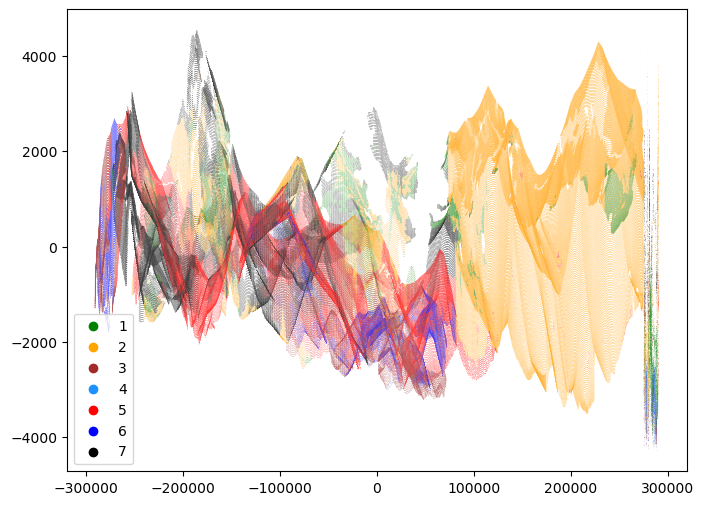

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Xtest_2D[:, 0], y=Xtest_2D[:, 1], s=0.1, hue=y_pred,
                palette=['green','orange','brown','dodgerblue','red', 'blue', 'black'])

### DBSCAN + weighted LGBoost

Avec class_weights

In [36]:
class_weights = {
    1: 0.4,
    2: 0.45,
    3: 0.04,
    4: 0.01,
    5: 0.04,
    6: 0.04,
    7: 0.04
}

coeffs = np.array([2.63, 3.06, 0.43, 0.05, 0.24, 0.27, 0.32])


clf = LGBMClassifier(
    objective='multiclass',
    num_class=7,
    class_weight=class_weights,
    boosting_type='gbdt',
    num_leaves=31,
    verbose=0,
    n_jobs=-1
)

def IWCV(df_train=df_train, 
         predictor=clf, 
         k_valid=10,
         coeffs=coeffs):
    """
    Inputs:
    df_train: training data
    predictor: classifier (can be a sklearn pipeline)
    k_valid: number of cross-validations desired
            
    Outputs:
    1. IWCV - unbiased estimate of test score if assumptions are correct
    2. clean_accuracies - array of estimated accuracy per class
    """    
        
    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']
    
    class_accuracies = np.zeros((k_valid, 7))
    
    for i in range(k_valid):
        data_train, data_test, target_train, target_test = train_test_split(
            X_train, y_train, test_size = 1 / k_valid
        )
        predictor.fit(data_train, target_train, categorical_feature=['Wilderness_Area_Synth', 'Soil_Type_Synth', 'DBScan'])
        y_pred = predictor.predict(data_test)

        for label in range(1,8):
            class_accuracies[i, label - 1] = accuracy_score(target_test[target_test == label], 
                                                        y_pred[target_test == label])
        IMCV = np.mean(class_accuracies @ coeffs) / np.sum(coeffs)
        
    return IMCV, class_accuracies.mean(axis=0)

In [29]:
IWCV(df_train=df_train, predictor=clf, k_valid=10)

(0.9508756390953464,
 array([0.97049881, 0.93588652, 0.89063411, 0.96995645, 0.98360417,
        0.94478499, 0.99149187]))

In [37]:
from utils import clean_predictor

X_train = df_train.drop('Cover_Type', axis=1)
y_train = df_train['Cover_Type']

clf.fit(X_train, y_train, categorical_feature=['Wilderness_Area_Synth', 'Soil_Type_Synth', 'DBScan'])
y_pred = clf.predict(df_test)

predictions_df = clean_predictor(y_pred)
predictions_df.to_csv(path_name + r'\test_predictions.csv', index=False) 

pd.Series(y_pred).value_counts()

2    240095
1    180425
7     51290
5     39937
3     39490
6     25676
4      4099
dtype: int64

Avec Sample_weight

In [31]:
sample_weight = pd.Series([coeffs[i - 1] for i in df_train["Cover_Type"]])

clf = LGBMClassifier(
    objective='multiclass',
    num_class=7,
    verbose=0,
    n_jobs=-1
)

def IWCV(df_train=df_train, 
         predictor=clf, 
         k_valid=10,
         coeffs=coeffs):
    """
    Inputs:
    df_train: training data
    predictor: classifier (can be a sklearn pipeline)
    k_valid: number of cross-validations desired
            
    Outputs:
    1. IWCV - unbiased estimate of test score if assumptions are correct
    2. clean_accuracies - array of estimated accuracy per class
    """    
        
    # Separate features and target 
    X_train = df_train.drop('Cover_Type', axis=1)
    y_train = df_train['Cover_Type']
    
    class_accuracies = np.zeros((k_valid, 7))
    
    for i in range(k_valid):
        data_train, data_test, target_train, target_test = train_test_split(
            X_train, y_train, test_size = 1 / k_valid
        )
        
        sample_weight_k = sample_weight[data_train.index]
        
        predictor.fit(data_train, target_train, categorical_feature=['Wilderness_Area_Synth', 'Soil_Type_Synth'], 
                      sample_weight=sample_weight_k)
        y_pred = predictor.predict(data_test)

        for label in range(1,8):
            class_accuracies[i, label - 1] = accuracy_score(target_test[target_test == label], 
                                                        y_pred[target_test == label])
        IMCV = np.mean(class_accuracies @ coeffs) / np.sum(coeffs)
        
    return IMCV, class_accuracies.mean(axis=0)

In [19]:
IWCV(df_train=df_train, predictor=clf, k_valid=10)

(0.9149757202610569,
 array([0.90475976, 0.91609465, 0.9042686 , 0.94180918, 0.9476904 ,
        0.90325539, 0.9837863 ]))

In [32]:
from utils import clean_predictor

clf.fit(X_train, y_train, categorical_feature=['Wilderness_Area_Synth', 'Soil_Type_Synth', 'DBScan'])
y_pred = clf.predict(df_test)

predictions_df = clean_predictor(y_pred)
predictions_df.to_csv(path_name + r'\test_predictions.csv', index=False) 

pd.Series(y_pred).value_counts()

2    233815
1    151830
7     71468
5     46499
3     39136
6     25780
4     12484
dtype: int64

### Without ID

In [63]:
df_test_nsid = df_test_ns.drop(columns="Id")

dbscan = DBSCAN(eps=200, min_samples=200, n_jobs=-1)
dbscan.fit(df_test_nsid)

DBSCAN(eps=200, min_samples=200, n_jobs=-1)

In [64]:
pd.Series(dbscan.labels_).value_counts()

 5     453939
-1     105184
 2      10125
 1       5624
 8        969
 12       785
 4        706
 11       533
 6        520
 3        437
 15       347
 10       327
 9        307
 13       304
 7        281
 0        255
 16       202
 14       167
dtype: int64

<Axes: >

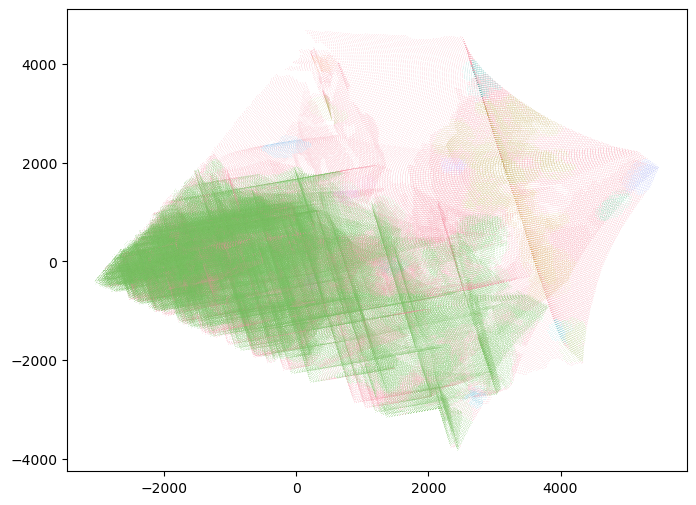

In [65]:
from sklearn.decomposition import PCA 
pca = PCA(n_components=2)
Xtest_2D = pca.fit_transform(df_test_nsid)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Xtest_2D[:, 0], y=Xtest_2D[:, 1], s=0.1, hue=dbscan.labels_,
                palette=sns.color_palette("husl", len(pd.Series(dbscan.labels_).value_counts())),
                legend=False)

In [66]:
df_test["DBScan"] = dbscan.labels_
df_train["DBScan"] = list(df_test[df_test["Id"].isin(df_train["Id"])]["DBScan"])

In [68]:
from lightgbm import LGBMClassifier
from utils import IWCV
IWCV(df_train=df_train, predictor=LGBMClassifier(), k_valid=10)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2432
[LightGBM] [Info] Number of data points in the train set: 13608, number of used features: 46
[LightGBM] [Info] Start training from score -1.941803
[LightGBM] [Info] Start training from score -1.947455
[LightGBM] [Info] Start training from score -1.938734
[LightGBM] [Info] Start training from score -1.949001
[LightGBM] [Info] Start training from score -1.939245
[LightGBM] [Info] Start training from score -1.952620
[LightGBM] [Info] Start training from score -1.952620
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2432
[LightGBM] [Info] Number of data points in the train set: 13608, number of used features: 46
[LightGBM] [Info] Start training from score 

(0.8144020618263375,
 array([0.8180665 , 0.7642792 , 0.87538281, 0.9693452 , 0.96051001,
        0.89474577, 0.9800611 ]))

In [70]:
from utils import clean_predictor

# Separate features and target 
X_train = df_train.drop('Cover_Type', axis=1)
y_train = df_train['Cover_Type']

# Initialize and train a Random Forest classifier
clf = LGBMClassifier(max_depth=10)
clf.fit(X_train, y_train)

# Make predictions on the test dataset
y_pred = clf.predict(df_test)

# Saving predictions to a CSV file
predictions_df = pd.DataFrame({'Cover_Type': y_pred})
predictions_df = clean_predictor(y_pred)

predictions_df.to_csv(path_name + r'\test_predictions.csv', index=False) # peut-être plus simple de directement mettre index = True

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2436
[LightGBM] [Info] Number of data points in the train set: 15120, number of used features: 46
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set 

### Si on scale sur df_test

In [192]:
df_test_ns_scaled = pd.DataFrame(StandardScaler().fit_transform(df_test_ns), columns=df_test_ns.columns)

In [193]:
dbscan = DBSCAN(eps=1, min_samples=100, n_jobs=-1)
dbscan.fit(df_test_ns_scaled)

KeyboardInterrupt: 

In [ ]:
pd.Series(dbscan.labels_).value_counts()

 0     243438
 7     225191
-1      54277
 8      28735
 13     25501
 2       1344
 15       458
 4        353
 6        257
 1        255
 11       196
 5        187
 10       166
 12       150
 16       139
 9        134
 14       131
 3        100
dtype: int64

<Axes: >

c:\Users\User\anaconda3\Lib\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


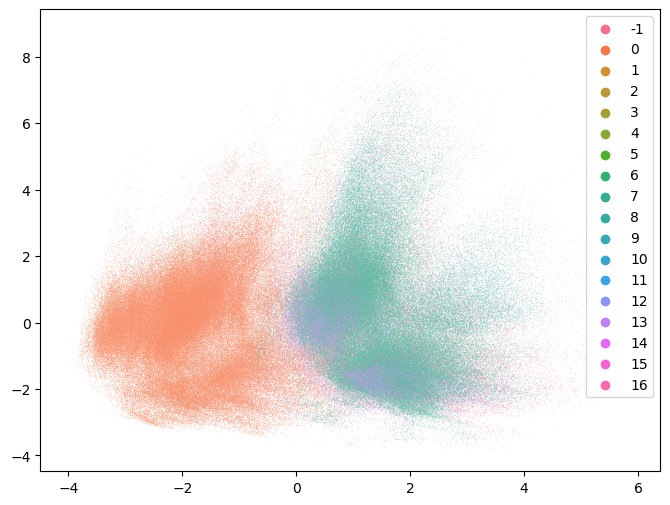

In [157]:
pca = PCA(n_components=2)
Xtest_2D = pca.fit_transform(df_test_ns_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=Xtest_2D[:, 0], y=Xtest_2D[:, 1], s=0.1, hue=dbscan.labels_,
                palette=sns.color_palette("husl", len(pd.Series(dbscan.labels_).value_counts())))

In [158]:
df_test["DBScan"] = dbscan.labels_
df_train["DBScan"] = list(df_test[df_test["Id"].isin(df_train["Id"])]["DBScan"])

pd.DataFrame(df_train["DBScan"].value_counts())

DBScan
 7     4989
 0     3186
-1     2951
 8     2414
 2      837
 13     414
 4      213
 1       41
 3       24
 12      15
 14      15
 11      10
 6        6
 15       2
 5        1
 10       1
 9        1

In [159]:
vc = pd.DataFrame(df_train["DBScan"].value_counts())
too_small = list(vc[vc["DBScan"] < 100].index)
df_test.loc[df_test["DBScan"].isin(too_small), "DBScan"] = -1
df_train.loc[df_train["DBScan"].isin(too_small), "DBScan"] = -1

In [160]:
from lightgbm import LGBMClassifier
from utils import IWCV
IWCV(df_train=df_train, predictor=LGBMClassifier(), k_valid=20)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2425
[LightGBM] [Info] Number of data points in the train set: 14364, number of used features: 46
[LightGBM] [Info] Start training from score -1.942505
[LightGBM] [Info] Start training from score -1.946398
[LightGBM] [Info] Start training from score -1.942990
[LightGBM] [Info] Start training from score -1.952266
[LightGBM] [Info] Start training from score -1.956197
[LightGBM] [Info] Start training from score -1.947373
[LightGBM] [Info] Start training from score -1.933801
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2426
[LightGBM] [Info] Number of data points in the train set: 14364, number of used features: 46
[LightGBM] [Info] Start training from score 

(0.8682742815244181,
 array([0.88565162, 0.82951668, 0.87053059, 0.97997138, 0.95180477,
        0.91714266, 0.9717087 ]))

In [161]:
from utils import clean_predictor

# Separate features and target 
X_train = df_train.drop('Cover_Type', axis=1)
y_train = df_train['Cover_Type']

# Initialize and train a Random Forest classifier
clf = LGBMClassifier()
clf.fit(X_train, y_train)

# Make predictions on the test dataset
y_pred = clf.predict(df_test)

# Saving predictions to a CSV file
predictions_df = pd.DataFrame({'Cover_Type': y_pred})
predictions_df = clean_predictor(y_pred)

predictions_df.to_csv(path_name + r'\test_predictions.csv', index=False) # peut-être plus simple de directement mettre index = True

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2428
[LightGBM] [Info] Number of data points in the train set: 15120, number of used features: 46
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


In [162]:
predictions_df["Cover_Type"].value_counts()

2    227752
7    106384
5     89935
1     78737
3     46419
6     27154
4      4631
Name: Cover_Type, dtype: int64

### PCA puis DBSCAN

In [8]:
pca = PCA(n_components=2)
Xtest_2D = pca.fit_transform(df_test_ns_scaled)

dbscan = DBSCAN(eps=0.1, min_samples=200, n_jobs=-1)
dbscan.fit(Xtest_2D)

DBSCAN(eps=0.1, min_samples=150, n_jobs=-1)

In [9]:
pd.Series(dbscan.labels_).value_counts()

 0    538681
-1     42230
 1       101
dtype: int64

<Axes: >

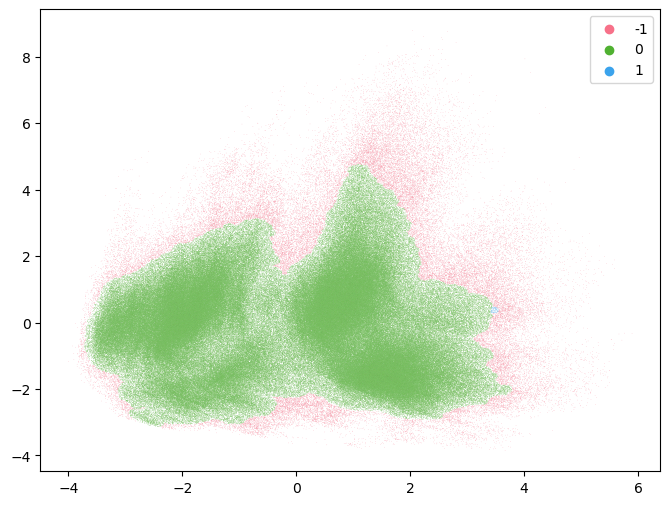

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Xtest_2D[:, 0], y=Xtest_2D[:, 1], s=0.1, hue=dbscan.labels_,
                palette=sns.color_palette("husl", len(pd.Series(dbscan.labels_).value_counts())))

# HDBScan

### Optics

In [45]:
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=100, n_jobs=-1)
optics.fit(df_train_ns)

KeyboardInterrupt: 

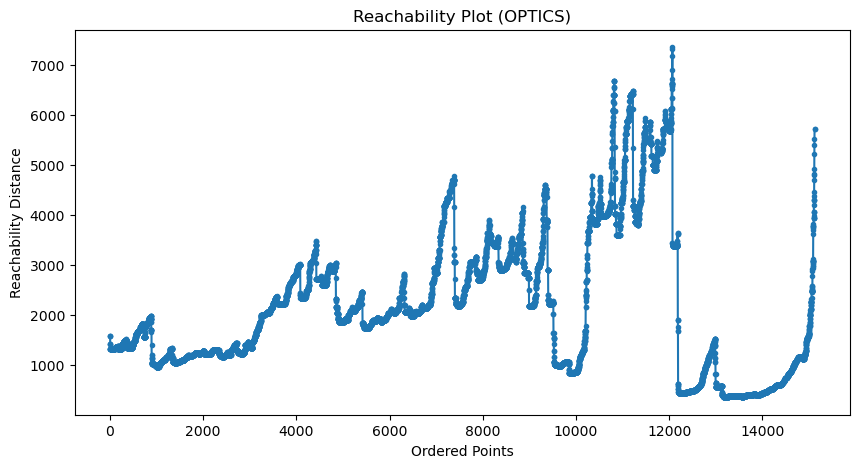

In [143]:
reachability = optics.reachability_[optics.ordering_]
plt.figure(figsize=(10, 5))
plt.plot(np.arange(len(reachability)), reachability, marker='.')
plt.title('Reachability Plot (OPTICS)')
plt.xlabel('Ordered Points')
plt.ylabel('Reachability Distance')
plt.show()

In [130]:
pd.Series(optics.labels_).value_counts()

-1    11185
 3     2908
 2      696
 0      181
 1      150
dtype: int64

In [ ]:
from sklearn.cluster import HDBSCAN
hdbscan = HDBSCAN()